In [1]:
import pandas
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

tasks:
    
    
de todos los assets de scentre queremos aplicar la plantilla del excell usando el resto de sources.
podriamos intentar hacer un modelo de specialiyy rent (market) y el cap rate. 

ask yi peng on how to curate data and how to calculate the cap rate

abs tiene mucha profunidad. Los forecast probablemente sean más fiables.

podemos borrar variables que tienen poco tiempo 





------

quitar samples that are asset-specific
Boruta para filtrar variables (extraer las predictivas).
KNN para el tratamiento geográfico.

## Data read 

In [2]:
base_actuals = pandas.read_csv('../data/output_actuals.csv', index_col=0)

/home/angel/Dropbox/Lurtis/Australia_miniproject/deciml_django/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
forecasts = pandas.read_csv('../data/output_forecasts.csv', index_col=0)

/home/angel/Dropbox/Lurtis/Australia_miniproject/deciml_django/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
base_actuals = base_actuals.rename(columns={
    'indicator__asset__asset_name':'asset', 
    'indicator__indicator_info_id':'indicator', 
    'indicator__location__name':'location', 
    'indicator__source__id':'source', 
    'indicator__uom':'uom'
})

forecasts = forecasts.rename(columns={
    'indicator__asset__asset_name':'asset', 
    'indicator__indicator_info__id':'indicator', 
    'indicator__location__name':'location', 
    'indicator__source__id':'source', 
    'indicator__uom':'uom'
})

In [5]:
base_actuals.indicator.unique()

array(['DWELLLING_INVEST', 'NET_ABSORP_QOQ', 'BUSINESS_INVEST',
       'ACCOUNT_BALANCE', 'TBOND', 'GDP', 'EQ_YIELD_UPPER_SEC',
       'POPULATION', 'BOOK_VALUE', 'OWNERSHIP', 'RES_BUILD_COMM_VAL',
       'FISCAL_BALANCE', 'REXPORT', 'NGDP', 'EXCHANGE_RATE',
       'NET_ABSORP_B_GRADE_YOY', 'RETAIL_PORT', 'SPECIALTY_OCC_COST',
       'INDPROD', 'RIMPORT', 'RFEDGOV', 'FOREIGN_INVEST',
       'EQ_AVG_YIELD_PRIME', 'CENTRE_SALES', 'CAR_PARK_SPACES',
       'OUTGOINGS', 'MONEY', 'CPI', 'MERCH_TRADE_BALANCE',
       'NET_EFFECT_RENT_GRTH_QOQ', 'PPI', 'PUBLIC_DEBT',
       'NET_ABSORP_A_GRADE_YOY', 'UNEMP', 'RCONSUM', 'STOCK_MARKET',
       'RETAIL_SALES', 'EQ_YIELD_UPPER_PRIME', 'DWELLING_OCC_RATE',
       'VALUATION', 'NET_LET_AREA', '90_BANK_BILL', 'FIXED_INVEST',
       'DISC_RATE', 'WA_LEASE_EXPIRY', 'CASH_RATE', 'LEASE_EXPIRY_2YAH',
       'NET_ABSORP_A_GRADE_QOQ', 'NET_ABSORP_B_GRADE_QOQ',
       'NET_EFFECT_RENT', 'LEASE_EXPIRY_4YAH', 'OCC_RATE', 'HOUSEHOLDS',
       'PASSING_RENT', 

In [6]:
base_actuals.head()

,date,asset,indicator,location,source,uom,value
0,2010-01-01,NaN,DWELLLING_INVEST,Australia,FOCUS,ann %,4.5
1,1993-01-01,NaN,NET_ABSORP_QOQ,CANBERRA Australian Capital Territory Australia,JLL,AUD/NLA,NaN
2,1993-10-01,NaN,NET_ABSORP_QOQ,CANBERRA Australian Capital Territory Australia,JLL,AUD/NLA,NaN
3,1994-04-01,NaN,NET_ABSORP_QOQ,CANBERRA Australian Capital Territory Australia,JLL,AUD/NLA,NaN
4,1994-07-01,NaN,NET_ABSORP_QOQ,CANBERRA Australian Capital Territory Australia,JLL,AUD/NLA,NaN


In [7]:
forecasts.head()

,date,forecaster_id,asset,indicator,location,source,uom,value
0,1998-04-01,NAIVE,NaN,NET_INCREASE_SEC_GRADE,SYDNEY New South Wales Australia,JLL,AUD/NLA,-10947.000
1,1998-04-01,RWD,NaN,NET_INCREASE_SEC_GRADE,SYDNEY New South Wales Australia,JLL,AUD/NLA,-9340.750
2,1998-04-01,SES,NaN,NET_INCREASE_SEC_GRADE,SYDNEY New South Wales Australia,JLL,AUD/NLA,-14676.065
3,1998-04-01,HOLT,NaN,NET_INCREASE_SEC_GRADE,SYDNEY New South Wales Australia,JLL,AUD/NLA,-20821.292
4,1998-04-01,DAMPED,NaN,NET_INCREASE_SEC_GRADE,SYDNEY New South Wales Australia,JLL,AUD/NLA,-3759.713


## Data preprocessing

In [8]:
def round_year(date):
    """
    Takes a string consisting on a date and returns the next
    day if it is the last day of the year. Otherwise it 
    return the same date.
    
    MAYBE ALSO HAPPENS FOR JUNE
    
    """
    year, month, day = date.split('-')
    if month=='12' and day=='31':
        year = int(year)+1
        month = '01'
        day = '01'
    date = '{year}-{month}-{day}'.format(year=year,
                                         month=month,
                                         day=day) 
    return date

In [9]:
base_actuals['date'] = pandas.to_datetime(base_actuals['date'])

In [10]:
# Droping the Na values (JLL is not stored)
print(base_actuals.shape)
actuals = base_actuals[~base_actuals['value'].isna()]
print(base_actuals.shape)

(97430, 7)
(97430, 7)


### Checking how it doesn't make much sense to keep indicators associated to assets

In [11]:
_ = base_actuals.set_index(['date', 'source', 'indicator', 'uom', 'location'])

In [12]:
_.loc['2009-06-30','STOCKLAND','VALUATION','AUDm','NORTH SYDNEY AU-NSW Australia']

/home/angel/Dropbox/Lurtis/Australia_miniproject/deciml_django/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


asset  \
date       source    indicator uom  location                                                     
2009-06-30 STOCKLAND VALUATION AUDm NORTH SYDNEY AU-NSW Australia  Macquarie Technology Centre   
                                    NORTH SYDNEY AU-NSW Australia      Triniti Business Campus   
                                    NORTH SYDNEY AU-NSW Australia                 Optus Centre   
                                    NORTH SYDNEY AU-NSW Australia          60-66 Waterloo Road   
                                    NORTH SYDNEY AU-NSW Australia           16 Giffnock Avenue   
                                    NORTH SYDNEY AU-NSW Australia            110 Walker Street   
                                    NORTH SYDNEY AU-NSW Australia           77 Pacific Highway   
                                    NORTH SYDNEY AU-NSW Australia            North West Sector   
                                    NORTH SYDNEY AU-NSW Australia             78 Waterloo Road   

                                                                    value  
date       source    indicator uom  location                               
2009-06-30 STOCKLAND VALUATION AUDm NORTH SYDNEY AU-NSW Australia    38.5  
                                    NORTH SYDNEY AU-NSW Australia   148.7  
                                    NORTH SYDNEY AU-NSW Australia   108.5  
                                    NORTH SYDNEY AU-NSW Australia    67.8  
                                    NORTH SYDNEY AU-NSW Australia    37.0  
                                    NORTH SYDNEY AU-NSW Australia    26.5  
                                    NORTH SYDNEY AU-NSW Australia    58.0  
                                    NORTH SYDNEY AU-NSW Australia  5388.0  
                                    NORTH SYDNEY AU-NSW Australia    64.7

As the dispersion is (obviously) very high, we cannot use asset-specific indicators until we have a reliable way of getting the proper geoscoped value.

In [13]:
print(len(base_actuals['indicator'].unique()))
actuals = base_actuals.loc[base_actuals['asset'].isna(),:]
actuals = actuals.drop('asset', axis=1)
print(len(actuals['indicator'].unique()))

176
144


Lots of indicators are deleted

### Checking how it doesn't make much sense to keep indicators associated to locations different than Australia (or target location)

In [14]:
(actuals.groupby(['date', 'source', 'indicator'])['value'].std()/\
actuals.groupby(['date', 'source', 'indicator'])['value'].mean()).dropna().sort_values(ascending=False)

date        source    indicator           
2017-12-31  ABS       NET_INWARD_MIGRATION         inf
2018-12-31  ABS       NET_INWARD_MIGRATION         inf
2015-12-31  ABS       POPULATION_DENSITY      2.130986
2014-12-31  ABS       POPULATION_DENSITY      2.125938
2013-12-31  ABS       POPULATION_DENSITY      2.121679
                                                ...   
2009-09-01  ABS       UNEMP                   0.040757
1992-07-01  ABS       UNEMP                   0.039814
2010-03-01  ABS       UNEMP                   0.037098
2011-01-01  ID_POPUL  AVG_HOUSEHOLD_SIZE      0.035618
                      DWELLING_OCC_RATE       0.013731
Name: value, Length: 1379, dtype: float64

In lots of case the variation coefficient is to hight to be useful. That's logical if we take into consideration that we are mixing indicators' values from different places.

In [15]:
print(len(actuals['indicator'].unique()))
actuals = actuals[actuals['location']=='Australia']
actuals = actuals.drop('location', axis=1)
print(len(actuals['indicator'].unique()))

144
36


In [16]:
actuals.head()

,date,indicator,source,uom,value
0,2010-01-01,DWELLLING_INVEST,FOCUS,ann %,4.500000
10,2012-01-01,BUSINESS_INVEST,FOCUS,ann %,17.200000
11,2012-01-01,ACCOUNT_BALANCE,FOCUS,% of GDP,-4.252392
12,2003-01-01,BUSINESS_INVEST,FOCUS,ann %,13.500000
13,2001-01-01,BUSINESS_INVEST,FOCUS,ann %,-5.600000


In [17]:
actuals_mat = actuals.pivot_table(index='date', columns=['indicator', 'uom', 'source'])

In [18]:
actuals_mat = actuals_mat.droplevel(axis=1, level=0)

Because we only have two variables with more than one unit of measure we will take the one of each with more data and drop the other.

In [19]:
actuals_mat.T.isna().sum(1)

indicator               uom              source
90_BANK_BILL            %                FOCUS     754
ACCOUNT_BALANCE         % of GDP         FOCUS     754
BUILDING_APPROVED       AUDth            ABS       550
BUSINESS_GROSS          AUDm             ABS       676
BUSINESS_INCOME         %                ABS       733
BUSINESS_INVEST         ann %            FOCUS     754
BUSINESS_LENDING        AUDth            ABS       575
CASH_RATE               %                FOCUS     754
CPI                     ann %            FOCUS     754
DWELLLING_INVEST        ann %            FOCUS     754
EXCHANGE_RATE           USD per AUD      FOCUS     754
FISCAL_BALANCE          % of GDP         FOCUS     754
FIXED_INVEST            ann %            FOCUS     754
FOREIGN_INVEST          USDb             FOCUS     754
GDP                     AUDm             ABS       713
                        ann %            FOCUS     754
GROSS_DISP_INC          AUDm             ABS       744
INDPROD          

In [20]:
actuals_mat = actuals_mat.drop(('GDP', 'ann %', 'FOCUS'), axis=1)
actuals_mat = actuals_mat.drop(('UNEMP', '%', 'ABS'), axis=1)

In [21]:
actuals_mat['year'] = actuals_mat.index.year

In [22]:
actuals_mat = actuals_mat.groupby('year').last()
# We keep the last value for each year, theoretically making the measure yearly

In [23]:
(~actuals_mat.isna()).sum(axis=1)
# Most of the data is empty for the majority of the years. Things get useful from 2000's on

year
1956     2
1957     2
1958     2
1959     3
1960     3
        ..
2015    35
2016    34
2017    34
2018    34
2019     5
Length: 64, dtype: int64

In [24]:
(~actuals_mat.isna()).sum(axis=0)

indicator               uom              source
90_BANK_BILL            %                FOCUS     19
ACCOUNT_BALANCE         % of GDP         FOCUS     19
BUILDING_APPROVED       AUDth            ABS       20
BUSINESS_GROSS          AUDm             ABS       25
BUSINESS_INCOME         %                ABS       11
BUSINESS_INVEST         ann %            FOCUS     19
BUSINESS_LENDING        AUDth            ABS       17
CASH_RATE               %                FOCUS     19
CPI                     ann %            FOCUS     19
DWELLLING_INVEST        ann %            FOCUS     19
EXCHANGE_RATE           USD per AUD      FOCUS     19
FISCAL_BALANCE          % of GDP         FOCUS     19
FIXED_INVEST            ann %            FOCUS     19
FOREIGN_INVEST          USDb             FOCUS     19
GDP                     AUDm             ABS       60
GROSS_DISP_INC          AUDm             ABS       29
INDPROD                 ann %            FOCUS     19
MERCH_TRADE_BALANCE     USDb      

In [25]:
#We discard dates with low number of samples.

actuals_mat = actuals_mat[(~actuals_mat.isna()).sum(axis=1)>10]

#We discarrd series with low number of samples
actuals_mat = actuals_mat.loc[:,((~actuals_mat.isna()).sum(axis=0)>15).values]

#We calculate the correlation matrix
actuals_corr = actuals_mat.corr()

In [35]:
mms = MinMaxScaler()
actuals_mat_s = pandas.DataFrame(mms.fit_transform(actuals_mat), 
                                 index=actuals_mat.index, 
                                 columns=actuals_mat.columns)

actuals_corr_s = actuals_mat_s.corr()

In [27]:
actuals_mat.columns.levels[0]

Index(['90_BANK_BILL', 'ACCOUNT_BALANCE', 'BUILDING_APPROVED',
       'BUSINESS_GROSS', 'BUSINESS_INCOME', 'BUSINESS_INVEST',
       'BUSINESS_LENDING', 'CASH_RATE', 'CPI', 'DWELLLING_INVEST',
       'EXCHANGE_RATE', 'FISCAL_BALANCE', 'FIXED_INVEST', 'FOREIGN_INVEST',
       'GDP', 'GROSS_DISP_INC', 'INDPROD', 'MERCH_TRADE_BALANCE', 'MONEY',
       'NET_OVERSEAS_MIGRATION', 'NGDP', 'POPULATION', 'PPI', 'PUBLIC_DEBT',
       'RCONSUM', 'RES_BUILD_APPROV', 'RES_BUILD_VAL', 'RETAIL_SALES',
       'RET_TURNOVER', 'REXPORT', 'RFEDGOV', 'RIMPORT', 'STOCK_MARKET',
       'TBOND', 'UNEMP', 'WHITE_COLLAR_EMPL', 'year'],
      dtype='object', name='indicator')

In [28]:
actuals_mat.shape

(19, 34)

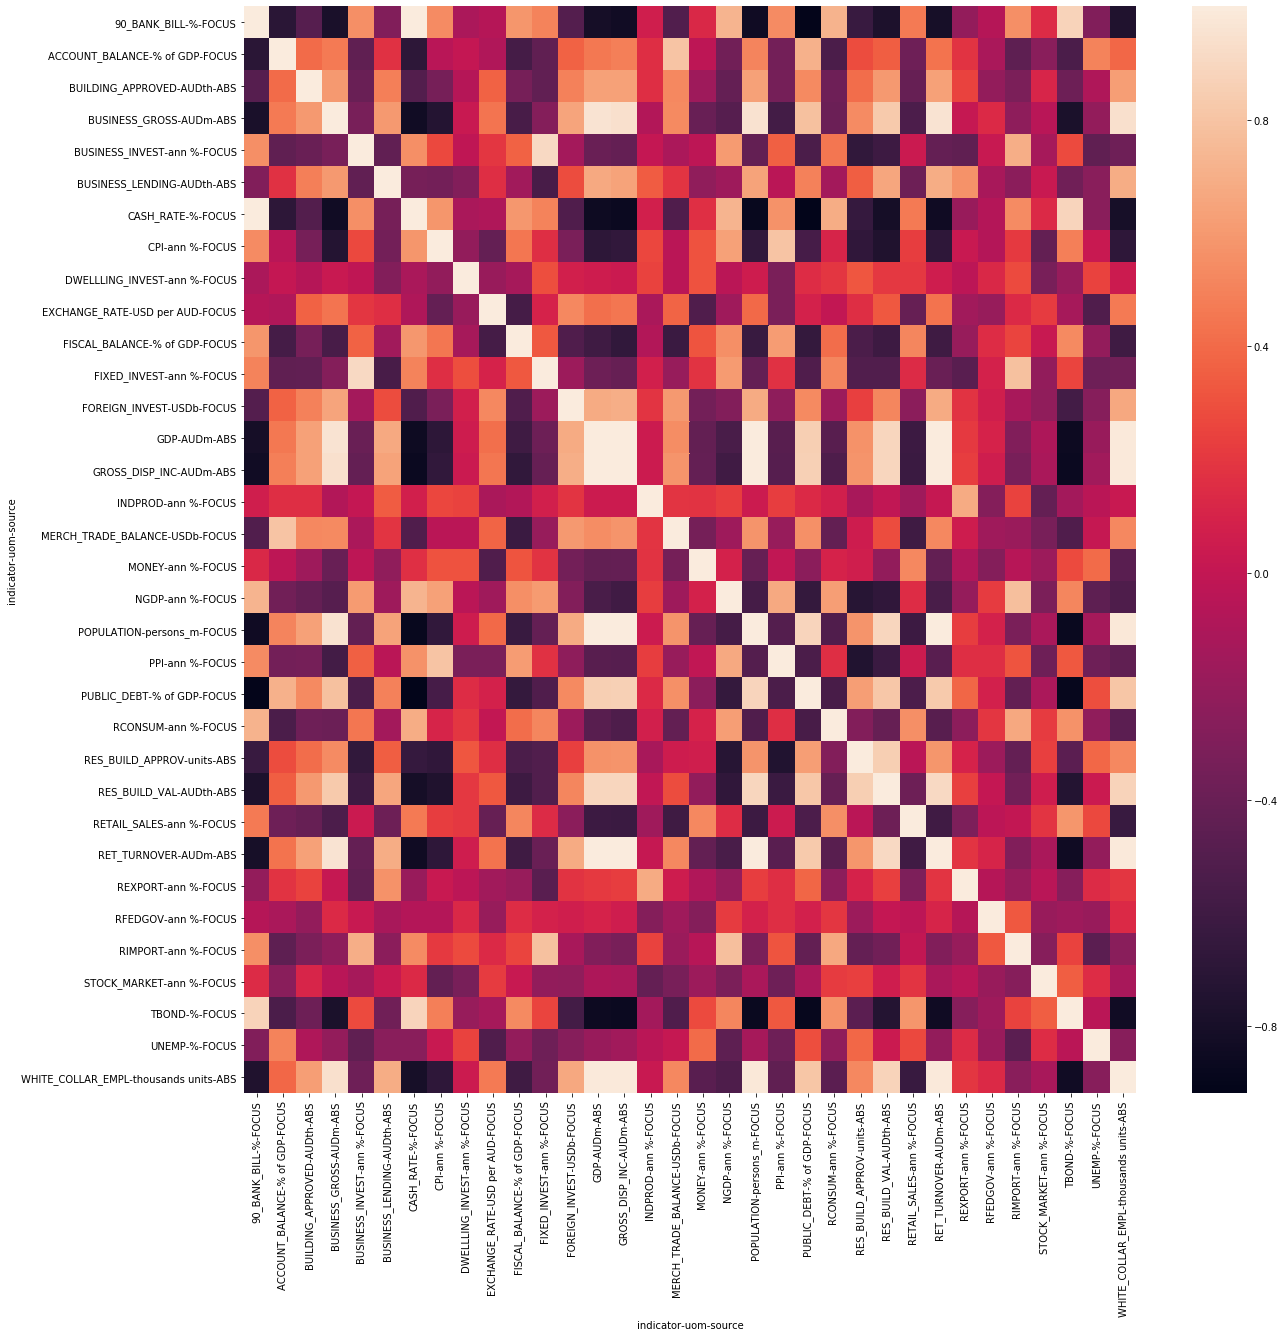

In [29]:
plt.figure(figsize=(20,20))
sns.heatmap(actuals_corr)
plt.show()

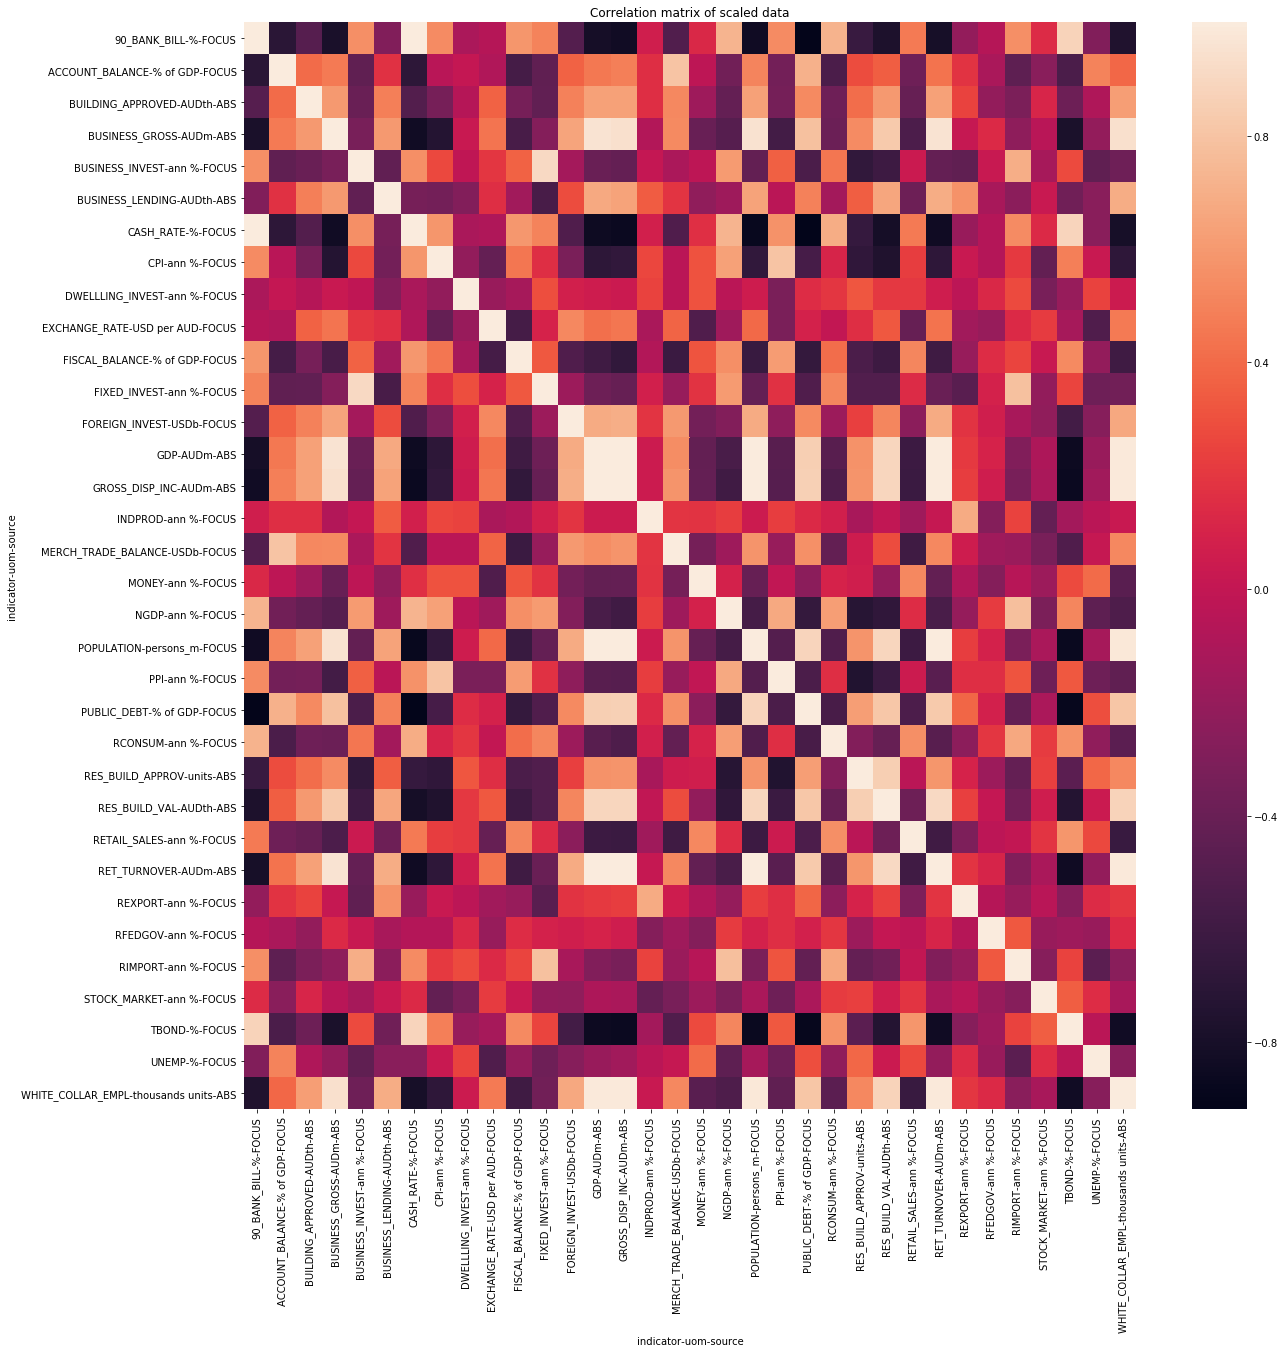

In [37]:
plt.figure(figsize=(20,20))
sns.heatmap(actuals_corr_s)
plt.title('Correlation matrix of scaled data')
plt.show()

In [38]:
actuals_corr_plain_df = actuals_corr.droplevel([1,2]).droplevel([1,2],axis=1)
actuals_corr_plain_df_s = actuals_corr_s.droplevel([1,2]).droplevel([1,2],axis=1)

In [39]:
corrs = actuals_corr_plain_df.abs()\
                .unstack(0)\
                .sort_values(ascending=False)\
                .dropna()\
                [len(actuals_corr.columns):] #we don't want same columns

corrs_s = actuals_corr_plain_df_s.abs()\
                                 .unstack(0)\
                                 .sort_values(ascending=False)\
                                 .dropna()\
                                 [len(actuals_corr_s.columns):] #we don't want same columns 

In [40]:
correlated_indicators = corrs[corrs>0.95].reset_index(level=1)['indicator'].unique()
correlated_indicators_s = corrs_s[corrs_s>0.95].reset_index(level=1)['indicator'].unique()

In [42]:
corrs.drop_duplicates().iloc[0:15]

indicator          indicator        
RET_TURNOVER       GDP                  0.997510
GDP                POPULATION           0.997265
CASH_RATE          90_BANK_BILL         0.996028
GROSS_DISP_INC     POPULATION           0.995935
GDP                GROSS_DISP_INC       0.994760
RET_TURNOVER       POPULATION           0.993589
GROSS_DISP_INC     RET_TURNOVER         0.992794
WHITE_COLLAR_EMPL  RET_TURNOVER         0.991364
                   GDP                  0.990914
                   GROSS_DISP_INC       0.986305
POPULATION         WHITE_COLLAR_EMPL    0.983739
GDP                BUSINESS_GROSS       0.956624
BUSINESS_GROSS     RET_TURNOVER         0.955946
POPULATION         BUSINESS_GROSS       0.951666
BUSINESS_GROSS     GROSS_DISP_INC       0.941229
dtype: float64

In [41]:
corrs_s.drop_duplicates().iloc[0:15]

indicator          indicator        
RET_TURNOVER       GDP                  0.997510
GDP                POPULATION           0.997265
CASH_RATE          90_BANK_BILL         0.996028
GROSS_DISP_INC     POPULATION           0.995935
GDP                GROSS_DISP_INC       0.994760
RET_TURNOVER       POPULATION           0.993589
GROSS_DISP_INC     RET_TURNOVER         0.992794
WHITE_COLLAR_EMPL  RET_TURNOVER         0.991364
                   GDP                  0.990914
                   GROSS_DISP_INC       0.986305
POPULATION         WHITE_COLLAR_EMPL    0.983739
GDP                BUSINESS_GROSS       0.956624
BUSINESS_GROSS     RET_TURNOVER         0.955946
POPULATION         BUSINESS_GROSS       0.951666
BUSINESS_GROSS     GROSS_DISP_INC       0.941229
dtype: float64

In [140]:
correlated_indicators

array(['GDP', 'RET_TURNOVER', 'POPULATION', '90_BANK_BILL', 'CASH_RATE',
       'GROSS_DISP_INC', 'WHITE_COLLAR_EMPL', 'BUSINESS_GROSS'],
      dtype=object)

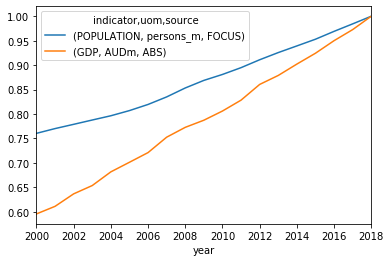

In [141]:
actuals_mat[['POPULATION','GDP']].dropna()\
                                   .div(actuals_mat[['POPULATION','GDP']].max())\
                                   .plot()
plt.show()

In [160]:
def retrieve_cap_rate(baseactuals, location):
    _ = baseactuals[baseactuals['location']==location]
    return _
    

In [163]:
[x for x in base_actuals.location.unique() if 'air' in x.lower()]

['FAIRFIELD Australia',
 'Erina Fair New South Wales Australia',
 'Fairfield City FAIRFIELD Australia',
 'CAIRNS Australia',
 'Airport West VIC AU',
 'CAIRNS AU-QLD Australia']

In [159]:
base_actuals.pivot_table(index='date', columns=['indicator', 'uom', 'source'])

value                                                 \
indicator  90_BANK_BILL ACCOUNT_BALANCE AVG_HOUSEHOLD_SIZE  BOOK_VALUE   
uom                   %        % of GDP            persons        AUDm   
source            FOCUS           FOCUS           ID_POPUL   STOCKLAND   
date                                                                     
1956-01-01          NaN             NaN                NaN         NaN   
1956-02-01          NaN             NaN                NaN         NaN   
1956-03-01          NaN             NaN                NaN         NaN   
1956-04-01          NaN             NaN                NaN         NaN   
1956-05-01          NaN             NaN                NaN         NaN   
1956-06-01          NaN             NaN                NaN         NaN   
1956-07-01          NaN             NaN                NaN         NaN   
1956-08-01          NaN             NaN                NaN         NaN   
1956-09-01          NaN             NaN                NaN         NaN   
1956-10-01          NaN             NaN                NaN         NaN   
1956-11-01          NaN             NaN                NaN         NaN   
1956-12-01          NaN             NaN                NaN         NaN   
1957-01-01          NaN             NaN                NaN         NaN   
1957-02-01          NaN             NaN                NaN         NaN   
1957-03-01          NaN             NaN                NaN         NaN   
1957-04-01          NaN             NaN                NaN         NaN   
1957-05-01          NaN             NaN                NaN         NaN   
1957-06-01          NaN             NaN                NaN         NaN   
1957-07-01          NaN             NaN                NaN         NaN   
1957-08-01          NaN             NaN                NaN         NaN   
1957-09-01          NaN             NaN                NaN         NaN   
1957-10-01          NaN             NaN                NaN         NaN   
1957-11-01          NaN             NaN                NaN         NaN   
1957-12-01          NaN             NaN                NaN         NaN   
1958-01-01          NaN             NaN                NaN         NaN   
1958-02-01          NaN             NaN                NaN         NaN   
1958-03-01          NaN             NaN                NaN         NaN   
1958-04-01          NaN             NaN                NaN         NaN   
1958-05-01          NaN             NaN                NaN         NaN   
1958-06-01          NaN             NaN                NaN         NaN   
...                 ...             ...                ...         ...   
2017-04-01          NaN             NaN                NaN         NaN   
2017-05-01          NaN             NaN                NaN         NaN   
2017-06-01          NaN             NaN                NaN         NaN   
2017-06-30          NaN             NaN                NaN  161.299184   
2017-07-01          NaN             NaN                NaN         NaN   
2017-08-01          NaN             NaN                NaN         NaN   
2017-09-01          NaN             NaN                NaN         NaN   
2017-10-01          NaN             NaN                NaN         NaN   
2017-11-01          NaN             NaN                NaN         NaN   
2017-12-01          NaN             NaN                NaN         NaN   
2017-12-31          NaN             NaN                NaN  169.854167   
2018-01-01         2.02       -2.060623                NaN         NaN   
2018-02-01          NaN             NaN                NaN         NaN   
2018-03-01          NaN             NaN                NaN         NaN   
2018-04-01          NaN             NaN                NaN         NaN   
2018-05-01          NaN             NaN                NaN         NaN   
2018-06-01          NaN             NaN                NaN         NaN   
2018-06-30          NaN             NaN                NaN  181.653614   
2018-07-01          Na

### Simple model for CAP_RATE

In [126]:
from sklearn.ensemble import RandomForestRegressor

In [239]:
cap_data = actuals_mat[~actuals_mat['CAP_RATE'].isna()]

cap_data = cap_data.loc[:,~cap_data.isna().all()]

cap_data.index = pandas.to_datetime(cap_data.index)

cap_data = cap_data.interpolate(method='time', limit_direction='both')

In [240]:
rfr = RandomForestRegressor(n_estimators=10)

In [241]:
cap_data_train = cap_data.iloc[0:int(cap_data.shape[0]*0.75)]
cap_data_test = cap_data.iloc[cap_data_train.shape[0]:]
print(cap_data_train.shape[0])

15


In [242]:
cap_data_train

indicator,BOOK_VALUE,BUILDING_APPROVED,BUSINESS_LENDING,CAP_RATE,CAR_PARK_SPACES,CENTRE_SALES,COST,DISC_RATE,GDP,OFFICE_PORT,...,POPULATION,RES_BUILD_APPROV,RES_BUILD_VAL,RETAIL_PORT,RET_TURNOVER,SETTLED,SPECIALTY_OCC_COST,TOTAL_LOTS,UNEMP,VALUATION
date,,,,,,,,,,,,,,,,,,,,,
2008-06-30,94.381410,256420.000000,5.887257e+07,6.731169,610.226667,129.797222,62.876923,8.732571,1.900000,2.564103,...,8.869135e+04,7355.000000,1.748978e+06,2.564103,4326.200000,48.315789,12.057143,1289.226562,4.900589,2016.651466
2009-01-01,97.091759,256420.000000,5.887257e+07,10.501736,676.094595,136.858824,68.890253,9.161972,1.900000,2.777778,...,2.186600e+01,7355.000000,1.748978e+06,2.631579,4326.200000,46.425342,12.010000,1281.030769,4.900589,1977.972034
2009-06-30,92.530556,290628.383562,5.077025e+07,7.788027,639.583333,135.345714,70.487083,9.314812,2.146575,3.030303,...,9.058139e+04,9582.068493,2.227308e+06,2.564103,4390.254795,48.495716,12.719355,1031.085714,5.024294,3299.080741
2010-01-01,93.152113,325787.000000,4.244286e+07,7.961739,697.101449,129.608108,75.540000,9.295000,2.400000,3.225806,...,2.217200e+01,11871.000000,2.718925e+06,2.541026,4456.088889,49.487805,12.430000,1328.250000,5.151434,1774.216667
2010-06-30,96.698913,281461.630137,4.678511e+07,8.021343,703.149254,139.705714,78.054412,9.447761,2.597260,3.225806,...,9.204365e+04,11061.739726,2.638592e+06,2.628947,4498.006697,54.081448,13.218438,1370.384375,5.170054,202.851610
2011-01-01,99.991045,235905.000000,5.124799e+07,7.926364,1143.876923,142.648571,78.952239,9.449394,2.800000,3.571429,...,8.766363e+04,10230.000000,2.556028e+06,2.564103,4541.088889,56.350000,13.818519,1551.814286,5.189192,1320.485795
2012-01-01,103.170769,346294.000000,5.181662e+07,7.898525,796.524590,142.407895,80.672308,9.494333,3.900000,33.041667,...,2.292800e+01,8731.000000,2.259094e+06,18.375610,4658.633333,55.173913,13.885714,1607.364865,5.237600,1360.647727
2012-06-30,108.215873,450391.254098,4.855412e+07,7.935161,842.885246,147.242105,84.000000,9.502419,3.009836,4.761905,...,9.470004e+04,9545.994536,2.508172e+06,17.938095,4743.473649,50.744681,13.925806,1662.927536,5.455788,1392.090230
2013-01-01,118.440678,556789.000000,4.521952e+07,7.622566,1295.972973,214.254545,91.644068,9.489655,2.100000,5.555556,...,2.329800e+01,10379.000000,2.762754e+06,22.721951,4830.188889,50.625000,14.746939,1654.159420,5.678799,1363.536364


In [243]:
rfr.fit(X=cap_data_train.drop('CAP_RATE', axis=1), y=cap_data_train['CAP_RATE'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [244]:
rfr.score(X=cap_data_train.drop('CAP_RATE', axis=1), y=cap_data_train['CAP_RATE'])

0.7629714247861804

In [245]:
rfr.score(X=cap_data_test.drop('CAP_RATE', axis=1), y=cap_data_test['CAP_RATE'])

-4.918633462386748

In [252]:
from sklearn.metrics import mean_absolute_error

In [253]:
mean_absolute_error(cap_data_test['CAP_RATE'], rfr.predict(cap_data_test.drop('CAP_RATE', axis=1)))

0.9361634355585792

In [249]:
cap_data_test['CAP_RATE']

date
2016-06-30    6.780612
2017-01-01    5.975128
2017-06-30    6.387292
2018-01-01    5.660819
2018-06-30    5.784051
2019-01-01    5.661571
Name: CAP_RATE, dtype: float64

In [248]:
rfr.predict(cap_data_test.drop('CAP_RATE', axis=1))

array([7.07433816, 6.82736168, 7.07433816, 6.85476581, 7.13881445,
       6.89683548])

In [ ]:
#'cost' y 'book_value' y 'valuation' son casi lo mismo. Ownership puede que no sirva. 'RES_BUILD_DONE_VAL', 'RES_BUILD_VAL' iguales.
